### 1- Importing Libraries

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
np.random.seed(3) 


c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


###  2- Importing all files

In [3]:
Peptides_data = pd.read_csv('train_peptides.csv')
Proteins_data = pd.read_csv('train_proteins.csv')
supplemental_clinical_data = pd.read_csv('supplemental_clinical_data.csv')
train_clinical_data = pd.read_csv('train_clinical_data.csv')


### 3- Discovering and cleaning Train Clinical Data 

In [4]:
train_clinical_data.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [5]:
train_clinical_data.isnull().sum()


visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

In [6]:
train_clinical_data.shape

(2615, 8)

Filling missing values in the updrs_1, updrs_2, and updrs_3 columns involved a process that ensured accurate imputation while considering each patient's data sequence. The function fill_missing_updrs123() was created to systematically handle missing values within patient groups. This function first performed forward-fill and backward-fill operations within each patient's data to replace missing values with the nearest available measurements before and after. By incorporating this function for each UPDRS column, we were able to maintain data integrity by utilizing the available information while accounting for temporal sequencing within patients' visits. The temporary columns created during this process were then dropped to maintain the cleanliness and organization of the data. However a different approach would be implemented for updrs_4

In [7]:


def fill_missing_updrs_123(data, updrs_column):
    # Create a temporary filled column within each patient group
    filled_column = f'{updrs_column}_filled'
    data[filled_column] = data.groupby('patient_id')[updrs_column].ffill()
    data[filled_column] = data.groupby('patient_id')[filled_column].bfill()
    data[updrs_column] = data[updrs_column].fillna(data[filled_column])
    
    # Dropping the temporary filled column
    data.drop(columns=filled_column, inplace=True)
    return data

# Filling missing values for UPDRS_1
train_clinical_data = fill_missing_updrs_123(train_clinical_data, 'updrs_1')

# Filling missing values for UPDRS_2
train_clinical_data = fill_missing_updrs_123(train_clinical_data, 'updrs_2')

# Filling missing values for UPDRS_3
train_clinical_data = fill_missing_updrs_123(train_clinical_data, 'updrs_3')


In [8]:
train_clinical_data.isnull().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   0
updrs_2                                   0
updrs_3                                   0
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

###### In addressing missing values within the updrs_4 column, a two-fold strategy was implemented. First, a binary indicator column, 'updrs_4_missing', was created to distinctly mark the initially missing values. This indicator serves as a valuable flag, indicating whether the patient's updrs_4 level was genuinely absent or started as 0. Subsequently, the missing values in updrs_4 were replaced with zeros. Even in cases where a patient's updrs_4 level might be naturally 0, the 'updrs_4_missing' column distinguishes between inherent zero levels and missing data. This dual approach not only addresses the missing values but also acknowledges both inherent zero levels and absent measurements.

In [9]:

# Creating a binary indicator column for missing UPDRS_4 values
train_clinical_data['updrs_4_missing'] = train_clinical_data['updrs_4'].isnull().astype(int)

# Filling missing values in UPDRS_4 with zeros
train_clinical_data['updrs_4'] = train_clinical_data['updrs_4'].fillna(0)


In [10]:
 train_clinical_data['clinical_state_on_medication'] =  train_clinical_data['upd23b_clinical_state_on_medication']

In [11]:

mode_per_patient = train_clinical_data.groupby('patient_id')['clinical_state_on_medication'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Merging the mode values back to the original dataframe
train_clinical_data = pd.merge(train_clinical_data, mode_per_patient, on='patient_id', how='left', suffixes=('', '_mode'))

# Filling missing values in 'clinical_state_on_medication' with the calculated modes
train_clinical_data['clinical_state_on_medication'] = train_clinical_data['clinical_state_on_medication'].fillna(train_clinical_data['clinical_state_on_medication_mode'])

# Dropping the temporary mode column
train_clinical_data.drop(columns='clinical_state_on_medication_mode', inplace=True)


In [12]:
del(train_clinical_data["upd23b_clinical_state_on_medication"])

In [13]:
train_clinical_data.isnull().sum()

visit_id                          0
patient_id                        0
visit_month                       0
updrs_1                           0
updrs_2                           0
updrs_3                           0
updrs_4                           0
updrs_4_missing                   0
clinical_state_on_medication    732
dtype: int64

###### filling missing values with 'unknown'

In [14]:
train_clinical_data['clinical_state_on_medication'].fillna('Unknown', inplace=True)


In [15]:
train_clinical_data.isna().sum()

visit_id                        0
patient_id                      0
visit_month                     0
updrs_1                         0
updrs_2                         0
updrs_3                         0
updrs_4                         0
updrs_4_missing                 0
clinical_state_on_medication    0
dtype: int64

In [16]:
train_clinical_data.shape

(2615, 9)

In [17]:
train_clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On
1,55_3,55,3,10.0,7.0,25.0,0.0,1,On
2,55_6,55,6,8.0,10.0,34.0,0.0,1,On
3,55_9,55,9,8.0,9.0,30.0,0.0,0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,0,On


### 4- Discovering and cleaning Supplemental Clinical Data 

######  supplemental_clinical_data is same as train_clinical_data so we will be foolowing the same claning strategy before we merge them into one data frame

In [18]:
supplemental_clinical_data.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN


In [19]:
supplemental_clinical_data.isnull().sum()


visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                 213
updrs_2                                 214
updrs_3                                   5
updrs_4                                 928
upd23b_clinical_state_on_medication    1101
dtype: int64

In [20]:

# Filling missing values for UPDRS_1
supplemental_clinical_data = fill_missing_updrs_123(supplemental_clinical_data, 'updrs_1')

# Filling missing values for UPDRS_2
supplemental_clinical_data = fill_missing_updrs_123(supplemental_clinical_data, 'updrs_2')

# Filling missing values for UPDRS_3
supplemental_clinical_data = fill_missing_updrs_123(supplemental_clinical_data, 'updrs_3')


In [21]:
supplemental_clinical_data.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                  96
updrs_2                                  96
updrs_3                                   3
updrs_4                                 928
upd23b_clinical_state_on_medication    1101
dtype: int64

In [22]:
# Displaying the rows with missing values in 'clinical_state_on_medication'
missing_values_mask = supplemental_clinical_data['updrs_1'].isnull()
rows_with_missing_values = supplemental_clinical_data[missing_values_mask]
print(rows_with_missing_values)


     visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
4       155_0         155            0      NaN      NaN      0.0      NaN   
27      889_0         889            0      NaN      NaN      0.0      NaN   
65     1663_0        1663            0      NaN      NaN      0.0      NaN   
85     2222_0        2222            0      NaN      NaN      0.0      NaN   
86     2331_0        2331            0      NaN      NaN      1.0      NaN   
...       ...         ...          ...      ...      ...      ...      ...   
2127  63278_0       63278            0      NaN      NaN      4.0      NaN   
2130  63335_0       63335            0      NaN      NaN      7.0      NaN   
2136  63479_0       63479            0      NaN      NaN      6.0      NaN   
2148  63774_0       63774            0      NaN      NaN      0.0      NaN   
2218  65382_0       65382            0      NaN      NaN      0.0      NaN   

     upd23b_clinical_state_on_medication  
4                   

###### these patients have most of their updrs level missing so it would be more accurate to just drop their correspening rows

In [23]:
supplemental_clinical_data.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3'], inplace=True)


In [24]:
supplemental_clinical_data.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   0
updrs_2                                   0
updrs_3                                   0
updrs_4                                 832
upd23b_clinical_state_on_medication    1004
dtype: int64

In [25]:
supplemental_clinical_data['updrs_4_missing'] = supplemental_clinical_data['updrs_4'].isnull().astype(int)
supplemental_clinical_data['updrs_4'] = supplemental_clinical_data['updrs_4'].fillna(0)

In [26]:
supplemental_clinical_data.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   0
updrs_2                                   0
updrs_3                                   0
updrs_4                                   0
upd23b_clinical_state_on_medication    1004
updrs_4_missing                           0
dtype: int64

In [27]:
supplemental_clinical_data['clinical_state_on_medication'] =  supplemental_clinical_data['upd23b_clinical_state_on_medication']

In [28]:
del(supplemental_clinical_data["upd23b_clinical_state_on_medication"])

In [29]:

mode_per_patient1 = supplemental_clinical_data.groupby('patient_id')['clinical_state_on_medication'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Merging the mode values back to the original dataframe
supplemental_clinical_data = pd.merge(supplemental_clinical_data, mode_per_patient1, on='patient_id', how='left', suffixes=('', '_mode'))

# Filling missing values in 'clinical_state_on_medication' with the calculated modes
supplemental_clinical_data['clinical_state_on_medication'] = supplemental_clinical_data['clinical_state_on_medication'].fillna(supplemental_clinical_data['clinical_state_on_medication_mode'])

# Dropping the temporary mode column
supplemental_clinical_data.drop(columns='clinical_state_on_medication_mode', inplace=True)


In [30]:
supplemental_clinical_data.isna().sum()

visit_id                          0
patient_id                        0
visit_month                       0
updrs_1                           0
updrs_2                           0
updrs_3                           0
updrs_4                           0
updrs_4_missing                   0
clinical_state_on_medication    469
dtype: int64

In [31]:
supplemental_clinical_data['clinical_state_on_medication'].fillna('Unknown', inplace=True)


In [32]:
supplemental_clinical_data.isna().sum()

visit_id                        0
patient_id                      0
visit_month                     0
updrs_1                         0
updrs_2                         0
updrs_3                         0
updrs_4                         0
updrs_4_missing                 0
clinical_state_on_medication    0
dtype: int64

In [33]:
supplemental_clinical_data.shape

(2125, 9)

### 5- Merging Train Clinical Data and Supplemental Clinical Data

###### Here we are going to combine both of our files (train_clinical_data and suppelemental_clinical_data) into one file

In [34]:
Final_clinical_data = pd.concat([train_clinical_data, supplemental_clinical_data])
Final_clinical_data.drop_duplicates(keep=False, inplace=True)

In [35]:
Final_clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On
1,55_3,55,3,10.0,7.0,25.0,0.0,1,On
2,55_6,55,6,8.0,10.0,34.0,0.0,1,On
3,55_9,55,9,8.0,9.0,30.0,0.0,0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,0,On


In [36]:
Final_clinical_data.shape

(4740, 9)

In [37]:
Final_clinical_data.duplicated().any()

False

In [38]:
Final_clinical_data.isna().sum()

visit_id                        0
patient_id                      0
visit_month                     0
updrs_1                         0
updrs_2                         0
updrs_3                         0
updrs_4                         0
updrs_4_missing                 0
clinical_state_on_medication    0
dtype: int64

###### The UPDRS (Unified Parkinson's Disease Rating Scale) is divided into four parts (1, 2, 3, and 4 which are updrs_1, updrs_2,updrs_3,updrs_4 respectively from our datasaet), each focusing on different aspects of Parkinson's disease. After thorough checkouts we unfodled that for research or clinical purposes, some studies or clinicians may use a total UPDRS score by summing the scores across all parts to get an overall measure of disease severity hence(Total_UPDRS). This total score would consider both motor and non-motor aspects of Parkinson's disease.

In [39]:


Final_clinical_data['Total_UPDRS'] = Final_clinical_data[['updrs_1','updrs_2','updrs_3', 'updrs_4']].sum(axis=1)

In [40]:
Final_clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On,31.0
1,55_3,55,3,10.0,7.0,25.0,0.0,1,On,42.0
2,55_6,55,6,8.0,10.0,34.0,0.0,1,On,52.0
3,55_9,55,9,8.0,9.0,30.0,0.0,0,On,47.0
4,55_12,55,12,10.0,10.0,41.0,0.0,0,On,61.0


###### Our first dataframe is clean and set for usage

### 6- Discovering Train Peptides 

In [41]:
Peptides_data.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [42]:
Peptides_data.shape

(981834, 6)

In [43]:

summed_peptide_data = Peptides_data.groupby(['visit_id'])['PeptideAbundance'].sum().reset_index()


In [44]:
summed_peptide_data

,visit_id,PeptideAbundance
0,10053_0,4.713352e+08
1,10053_12,4.666371e+08
2,10053_18,5.220732e+08
3,10138_12,6.515605e+08
4,10138_24,6.720870e+08
...,...,...
1108,8699_24,6.618368e+08
1109,942_12,5.540194e+08
1110,942_24,5.677032e+08
1111,942_48,5.979831e+08


In [45]:
from scipy import stats



In [46]:
Peptides_data['UniProt'].value_counts() #227 UniProt
Peptides_data['Peptide'].value_counts() #968 Peptide
Peptides_data['PeptideAbundance'].value_counts()

127056.0    10
144004.0    10
109591.0    10
103890.0     9
116278.0     9
            ..
21198.0      1
62987.2      1
182618.0     1
30224.1      1
12825.9      1
Name: PeptideAbundance, Length: 738931, dtype: int64

In [47]:
Peptides_data.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [48]:
Peptides = Peptides_data.groupby('visit_id')['PeptideAbundance'].sum().reset_index()
Peptides

,visit_id,PeptideAbundance
0,10053_0,4.713352e+08
1,10053_12,4.666371e+08
2,10053_18,5.220732e+08
3,10138_12,6.515605e+08
4,10138_24,6.720870e+08
...,...,...
1108,8699_24,6.618368e+08
1109,942_12,5.540194e+08
1110,942_24,5.677032e+08
1111,942_48,5.979831e+08


In [49]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
Peptide_Abundnace_Reshape = Peptides['PeptideAbundance'].values.reshape(-1, 1)
Peptides['Peptide Abundance Standardized'] = Scaler.fit_transform(Peptide_Abundnace_Reshape)

In [50]:
Peptides

,visit_id,PeptideAbundance,Peptide Abundance Standardized
0,10053_0,4.713352e+08,-1.035157
1,10053_12,4.666371e+08,-1.085926
2,10053_18,5.220732e+08,-0.486862
3,10138_12,6.515605e+08,0.912430
4,10138_24,6.720870e+08,1.134248
...,...,...,...
1108,8699_24,6.618368e+08,1.023480
1109,942_12,5.540194e+08,-0.141637
1110,942_24,5.677032e+08,0.006235
1111,942_48,5.979831e+08,0.333452


Our second dataset is clean and set for usage 

In [51]:
#Test : 
Total_PeptideAbu  = Peptides['PeptideAbundance'].sum()
Total_PeptideAbu_std  = Peptides['Peptide Abundance Standardized'].sum()

print(Total_PeptideAbu); print(Total_PeptideAbu_std)

631211501725.2501
-4.565237077258644e-13


### 7 - Discovering Train Protein

In [52]:
Proteins_data.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [53]:
Proteins_data.shape

(232741, 5)

In [54]:

Proteins = Proteins_data.groupby(['visit_id'])['NPX'].sum().reset_index()


In [55]:

Proteins.head()

,visit_id,NPX
0,10053_0,4.713356e+08
1,10053_12,4.666370e+08
2,10053_18,5.220732e+08
3,10138_12,6.515605e+08
4,10138_24,6.720872e+08


In [56]:
from sklearn.preprocessing import StandardScaler
Proteins= pd.DataFrame(Proteins)
scale= StandardScaler()
X_data = Proteins[['NPX']]
Proteins['Standardized_NPX'] = scale.fit_transform(X_data)
Proteins

,visit_id,NPX,Standardized_NPX
0,10053_0,4.713356e+08,-1.035152
1,10053_12,4.666370e+08,-1.085927
2,10053_18,5.220732e+08,-0.486861
3,10138_12,6.515605e+08,0.912430
4,10138_24,6.720872e+08,1.134250
...,...,...,...
1108,8699_24,6.618367e+08,1.023479
1109,942_12,5.540191e+08,-0.141641
1110,942_24,5.677028e+08,0.006231
1111,942_48,5.979835e+08,0.333456


In [57]:
#Test : 
Total_NPX  = Proteins['NPX'].sum()
Total_NPX_std  = Proteins['Standardized_NPX'].sum()

print(Total_NPX); print(Total_NPX_std)

631211499982.2302
-1.5987211554602254e-14


Our third Dataset is clean and ready for usage

### 8- Merging all three final Datasets

In [58]:
#MergingData 

Merged_data = pd.merge(Peptides, Proteins, on=['visit_id'])
 
Merged_data2 = pd.merge(Final_clinical_data, Merged_data, on='visit_id')

Final_merge = Merged_data2[['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'updrs_4_missing', 'clinical_state_on_medication', 'Total_UPDRS', 'NPX', 'PeptideAbundance', 'Standardized_NPX', 'Peptide Abundance Standardized']]

Final_merge

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS,NPX,PeptideAbundance,Standardized_NPX,Peptide Abundance Standardized
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On,31.0,6.965313e+08,6.965313e+08,1.398404,1.398403
1,55_6,55,6,8.0,10.0,34.0,0.0,1,On,52.0,6.413644e+08,6.413646e+08,0.802248,0.802250
2,55_12,55,12,10.0,10.0,41.0,0.0,0,On,61.0,6.983249e+08,6.983249e+08,1.417786,1.417786
3,55_36,55,36,17.0,18.0,51.0,0.0,0,On,86.0,7.649231e+08,7.649234e+08,2.137472,2.137476
4,942_6,942,6,8.0,2.0,21.0,0.0,1,Off,31.0,5.350061e+08,5.350063e+08,-0.347103,-0.347101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,64674_84,64674,84,11.0,15.0,45.0,4.0,0,Off,75.0,4.292280e+08,4.292285e+08,-1.490184,-1.490179
1064,65043_0,65043,0,2.0,6.0,16.0,0.0,1,Off,24.0,6.527176e+08,6.527175e+08,0.924935,0.924934
1065,65043_12,65043,12,4.0,7.0,14.0,0.0,0,Off,25.0,6.562130e+08,6.562133e+08,0.962707,0.962711
1066,65043_24,65043,24,4.0,8.0,13.0,0.0,0,Off,25.0,7.090661e+08,7.090660e+08,1.533859,1.533859


# II - DATA EXPLORATION

### 1 - Plotting clinical Data 


In [59]:
# Grouping the last visit_id based on Total UPDRS from the final clinical data.

Final_clinical_data_graphical = Final_merge.drop_duplicates(subset=['patient_id'], keep='last')
Final_clinical_data_graphical
UPDRS = Final_clinical_data_graphical['Total_UPDRS'].values
len(UPDRS)

248

In [60]:
Conditions = [

    Final_clinical_data_graphical["Total_UPDRS"] <= 15,

    (Final_clinical_data_graphical["Total_UPDRS"] > 16) & (Final_clinical_data_graphical["Total_UPDRS"] <= 40),

    (Final_clinical_data_graphical["Total_UPDRS"] > 41) & (Final_clinical_data_graphical["Total_UPDRS"] <= 70),

    (Final_clinical_data_graphical["Total_UPDRS"] > 71) & (Final_clinical_data_graphical["Total_UPDRS"] <= 100),

    Final_clinical_data_graphical["Total_UPDRS"] > 100

]
 
values = [0, 1, 2, 3, 4]

Final_clinical_data_graphical["UPDRS_Score"] = np.select(Conditions, values, default=0)
Final_clinical_data_graphical

C:\Users\Juan David\AppData\Local\Temp\ipykernel_13188\2054673643.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_clinical_data_graphical["UPDRS_Score"] = np.select(Conditions, values, default=0)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS,NPX,PeptideAbundance,Standardized_NPX,Peptide Abundance Standardized,UPDRS_Score
3,55_36,55,36,17.0,18.0,51.0,0.0,0,On,86.0,7.649231e+08,7.649234e+08,2.137472,2.137476,3
7,942_48,942,48,2.0,6.0,35.0,0.0,0,Off,43.0,5.979835e+08,5.979831e+08,0.333456,0.333452,2
11,1517_60,1517,60,19.0,18.0,39.0,10.0,0,Off,86.0,5.840639e+08,5.840636e+08,0.183036,0.183032,3
14,1923_36,1923,36,3.0,0.0,1.0,0.0,1,Unknown,4.0,7.711963e+08,7.711966e+08,2.205263,2.205267,0
18,2660_48,2660,48,6.0,0.0,0.0,0.0,1,Unknown,6.0,6.153522e+08,6.153520e+08,0.521149,0.521147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,63875_48,63875,48,3.0,0.0,2.0,0.0,0,Unknown,5.0,5.435102e+08,5.435107e+08,-0.255204,-0.255199,0
1052,63889_60,63889,60,6.0,5.0,28.0,2.0,0,Off,41.0,5.450832e+08,5.450833e+08,-0.238205,-0.238204,0
1057,64669_60,64669,60,15.0,15.0,38.0,0.0,0,Off,68.0,5.587043e+08,5.587045e+08,-0.091011,-0.091008,2
1063,64674_84,64674,84,11.0,15.0,45.0,4.0,0,Off,75.0,4.292280e+08,4.292285e+08,-1.490184,-1.490179,3


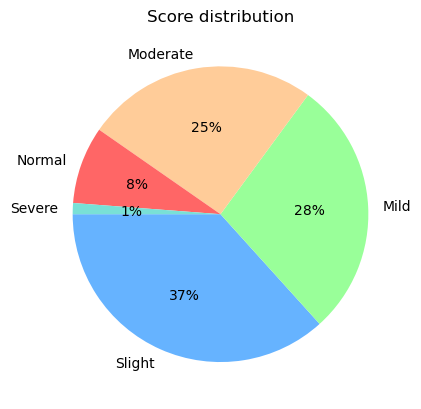

In [61]:
score_counts = Final_clinical_data_graphical["UPDRS_Score"].value_counts()
score_counts
labels = ['Slight', 'Mild', 'Moderate', 'Normal', 'Severe']
plt.pie(score_counts, autopct='%1.0f%%',labels=labels, startangle=180, colors=['#66b3ff','#99ff99','#ffcc99','#ff6666', '#79e0d6'])
plt.title('Score distribution')
 
plt.show()

In [62]:
# UPDRS Range values for each range 

Final_clinical_data_graphical['UPDRS_Score'].value_counts()

0    91
2    70
1    63
3    21
4     3
Name: UPDRS_Score, dtype: int64

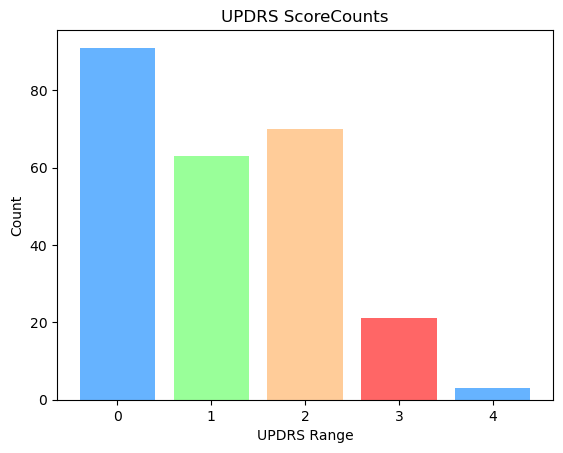

In [63]:
# Graphical representtaion of UPDRS_Score count.

Score_counts = Final_clinical_data_graphical['UPDRS_Score'].value_counts().sort_index()

# Plotting
plt.bar(Score_counts.index, Score_counts.values, color=['#66b3ff', '#99ff99', '#ffcc99', '#ff6666'])
plt.xlabel('UPDRS Range')
plt.ylabel('Count')
plt.title('UPDRS ScoreCounts')
#plt.xticks(range_counts.index, range_counts.index)

plt.show()



So for the next step we're going to choose a patient for each score categorie and visualize their different updrs levels and their UPDRS Total

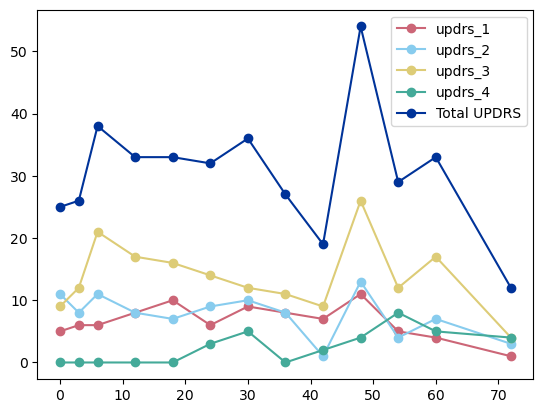

In [64]:
# Fetch data for a randomly chosen patient with id from categroy 0, patient : 6211		


plot_df = Final_clinical_data[Final_clinical_data["patient_id"]==6211]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="#CC6677", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="#88CCEE", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="#DDCC77", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="#44AA99", label="updrs_4", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['Total_UPDRS'], marker='o', color="#003399", label="Total UPDRS", linestyle="-")


ax.legend()
plt.show()


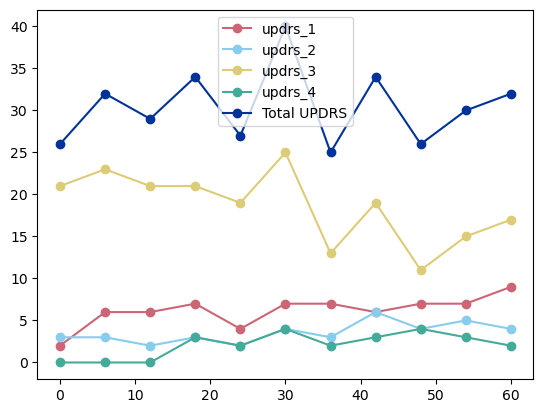

In [65]:
# Fetch data for a randomly chosen patient with id from categroy 3, patient : 4923	


plot_df = Final_clinical_data[Final_clinical_data["patient_id"]==4923]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="#CC6677", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="#88CCEE", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="#DDCC77", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="#44AA99", label="updrs_4", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['Total_UPDRS'], marker='o', color="#003399", label="Total UPDRS", linestyle="-")


ax.legend()
plt.show()


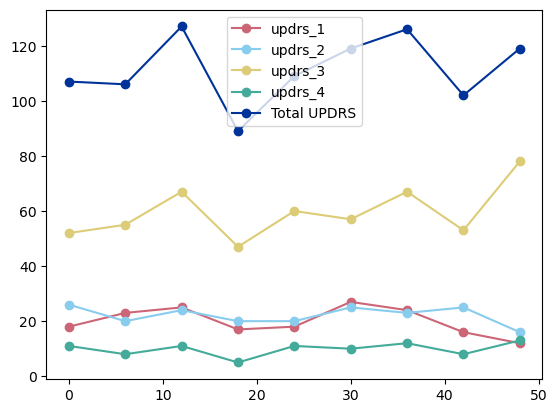

In [66]:
# Fetch data for a randomly chosen patient with id from categroy 4, patient : 40650


plot_df = Final_clinical_data[Final_clinical_data["patient_id"]== 40650]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="#CC6677", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="#88CCEE", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="#DDCC77", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="#44AA99", label="updrs_4", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['Total_UPDRS'], marker='o', color="#003399", label="Total UPDRS", linestyle="-")


ax.legend()
plt.show()


After individually analyzing five distinct patients, a recurring trend emerged where UPDRS3 consistently exhibited the highest scores among updrs_1, updrs_2, updrs_3, and updrs_4. This trend, observed across multiple patients, suggests that UPDRS3 might be a prominent contributing factor influencing the severity of Parkinson's disease symptoms for these individuals

In [67]:
len(Final_clinical_data_graphical)

248

### 2 - Stastical studies and observations 

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


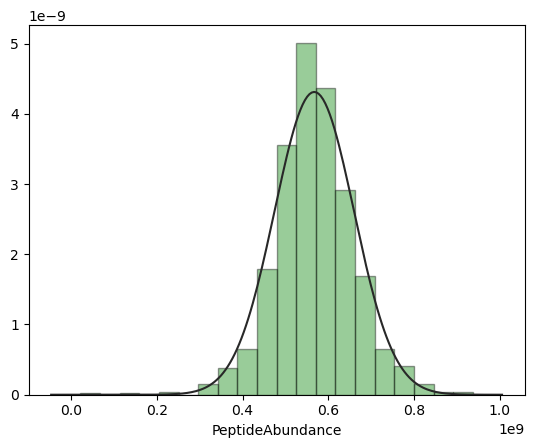

In [68]:

# Plotting the distribution of 'PeptideAbundance'

sns.distplot(Peptides['PeptideAbundance'], fit=norm, kde=False, bins=20, color='g', hist_kws={'edgecolor':'black'})
plt.show()


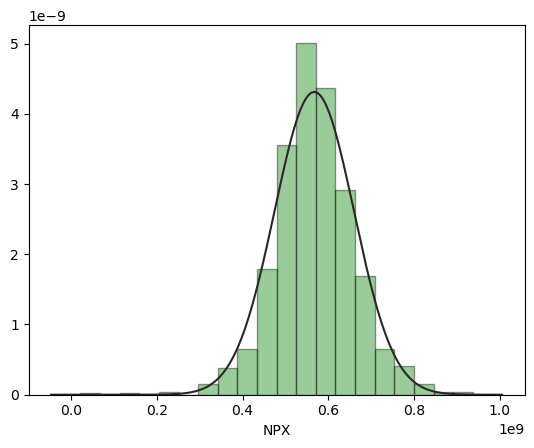

In [69]:
# Plotting the distribution of 'NPX' (same graph as above)

sns.distplot(Proteins['NPX'], fit=norm, kde=False, bins=20, color='g', hist_kws={'edgecolor':'black'})
plt.show()

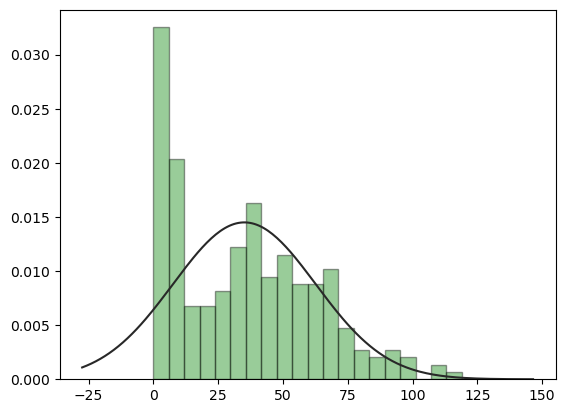

In [70]:

# Plotting the distribution of 'Total_UPDRS'

sns.distplot(UPDRS, fit=norm, kde=False, bins=20, color='g', hist_kws={'edgecolor':'black'})
plt.show()


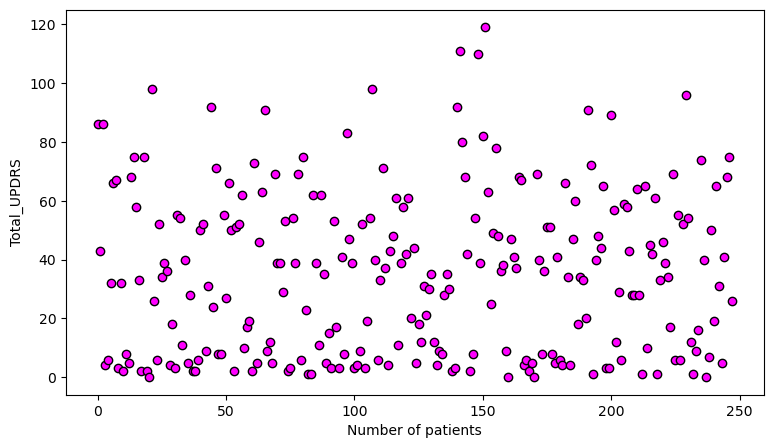

In [71]:

#creating a numpy array with our patients (instead of having unrognized numbers assigend to each patient we are rescaling from 1 to 562)

Patients = list(range(0,len(UPDRS)))
# Graphical representtaion of Total_UPDRS.
plt.figure(figsize=(9, 5))
plt.scatter(Patients, UPDRS, color='magenta', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('Total_UPDRS')
plt.show()

Text(0, 0.5, 'updrs_1')

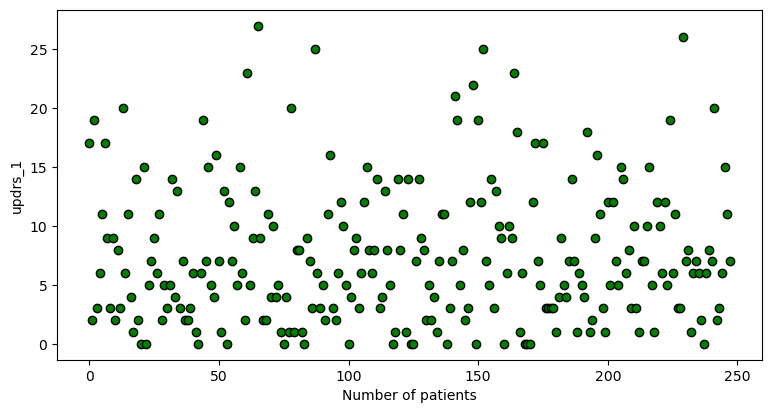

In [72]:
# Graphical representtaion of UPDRS_1.

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.scatter(Patients, Final_clinical_data_graphical['updrs_1'], color='g', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('updrs_1')

Varies between 0 and 35

Text(0, 0.5, 'updrs_2')

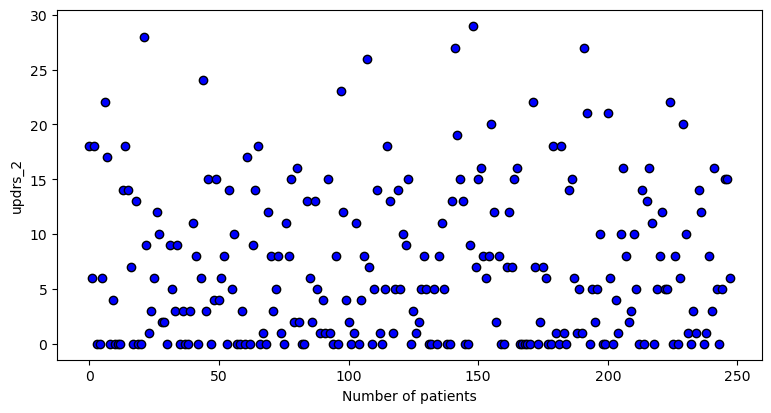

In [73]:
# Graphical representtaion of UPDRS_2.

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 2)
plt.scatter(Patients, Final_clinical_data_graphical['updrs_2'], color='b', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('updrs_2')

Varies between 0 and 42

Text(0, 0.5, 'updrs_3')

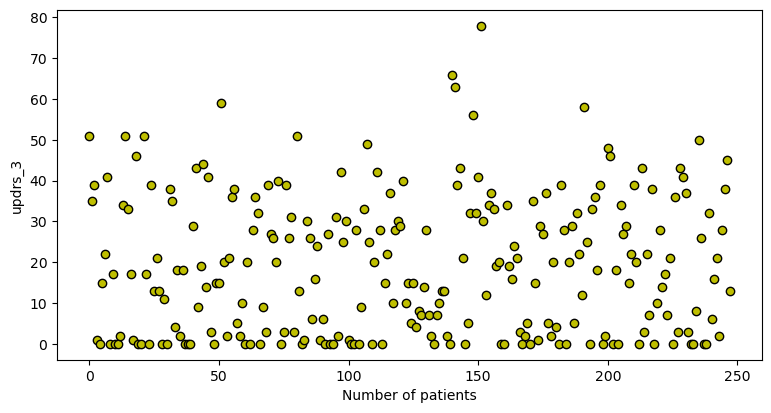

In [74]:
# Graphical representtaion of UPDRS_3.

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 3)
plt.scatter(Patients, Final_clinical_data_graphical['updrs_3'], color='y', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('updrs_3')

Varies between 0 and 85

Text(0, 0.5, 'updrs_4')

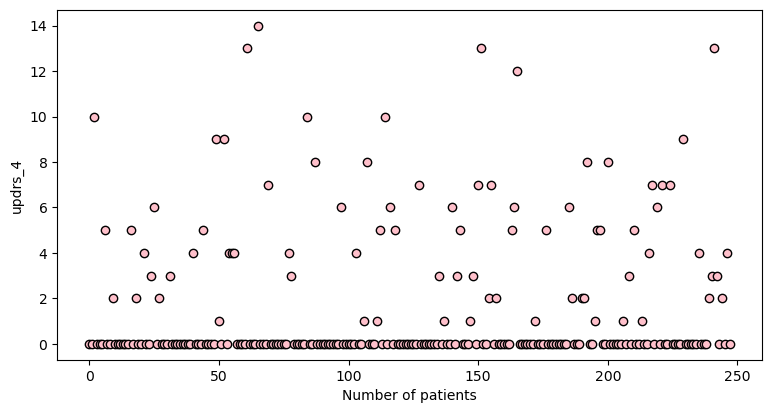

In [75]:
# Graphical representtaion of UPDRS_4.

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 4)
plt.scatter(Patients, Final_clinical_data_graphical['updrs_4'], color='pink', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('updrs_4')

Varies between 0 and 18

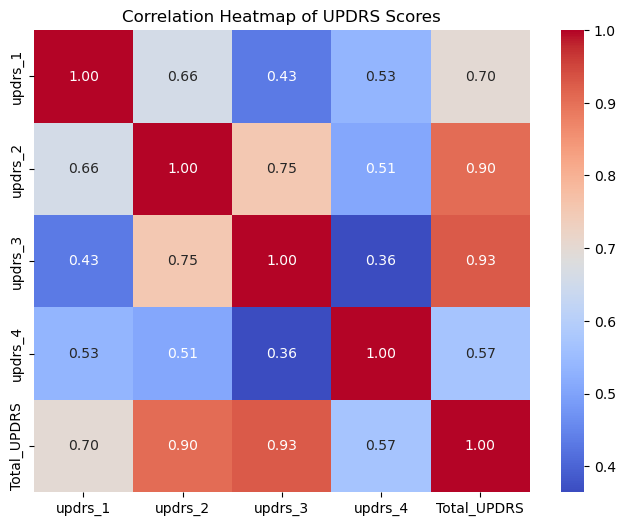

In [76]:

updrs_subset = Final_clinical_data_graphical[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'Total_UPDRS']]

correlation_matrix = updrs_subset.corr()

# Creating the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of UPDRS Scores')
plt.show()


updrs_2 and updrs_3 seem to be highly correlated with Total_UPDRS, which makes sense since they have the highest upper bound ranged compared to updrs_1 and updrs_2

In [77]:
Final_clinical_data_graphical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS,NPX,PeptideAbundance,Standardized_NPX,Peptide Abundance Standardized,UPDRS_Score
3,55_36,55,36,17.0,18.0,51.0,0.0,0,On,86.0,7.649231e+08,7.649234e+08,2.137472,2.137476,3
7,942_48,942,48,2.0,6.0,35.0,0.0,0,Off,43.0,5.979835e+08,5.979831e+08,0.333456,0.333452,2
11,1517_60,1517,60,19.0,18.0,39.0,10.0,0,Off,86.0,5.840639e+08,5.840636e+08,0.183036,0.183032,3
14,1923_36,1923,36,3.0,0.0,1.0,0.0,1,Unknown,4.0,7.711963e+08,7.711966e+08,2.205263,2.205267,0
18,2660_48,2660,48,6.0,0.0,0.0,0.0,1,Unknown,6.0,6.153522e+08,6.153520e+08,0.521149,0.521147,0


In [78]:
Final_clinical_data.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On,31.0
1,55_3,55,3,10.0,7.0,25.0,0.0,1,On,42.0
2,55_6,55,6,8.0,10.0,34.0,0.0,1,On,52.0
3,55_9,55,9,8.0,9.0,30.0,0.0,0,On,47.0
4,55_12,55,12,10.0,10.0,41.0,0.0,0,On,61.0


In [79]:
Final_merge.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS,NPX,PeptideAbundance,Standardized_NPX,Peptide Abundance Standardized
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On,31.0,6.965313e+08,6.965313e+08,1.398404,1.398403
1,55_6,55,6,8.0,10.0,34.0,0.0,1,On,52.0,6.413644e+08,6.413646e+08,0.802248,0.802250
2,55_12,55,12,10.0,10.0,41.0,0.0,0,On,61.0,6.983249e+08,6.983249e+08,1.417786,1.417786
3,55_36,55,36,17.0,18.0,51.0,0.0,0,On,86.0,7.649231e+08,7.649234e+08,2.137472,2.137476
4,942_6,942,6,8.0,2.0,21.0,0.0,1,Off,31.0,5.350061e+08,5.350063e+08,-0.347103,-0.347101


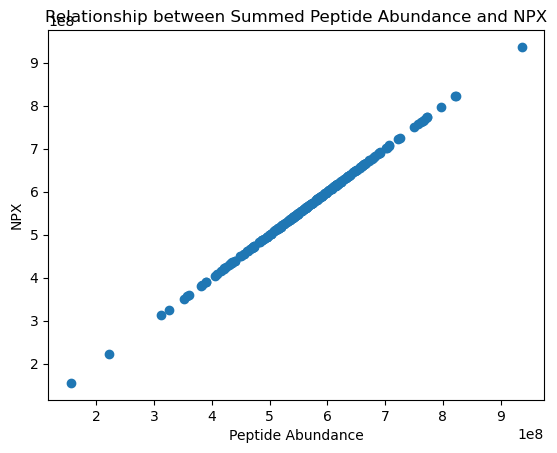

In [80]:

plt.scatter(Final_clinical_data_graphical['PeptideAbundance'], Final_clinical_data_graphical['NPX'])
plt.xlabel('Peptide Abundance')
plt.ylabel('NPX')
plt.title('Relationship between Summed Peptide Abundance and NPX')
plt.show()


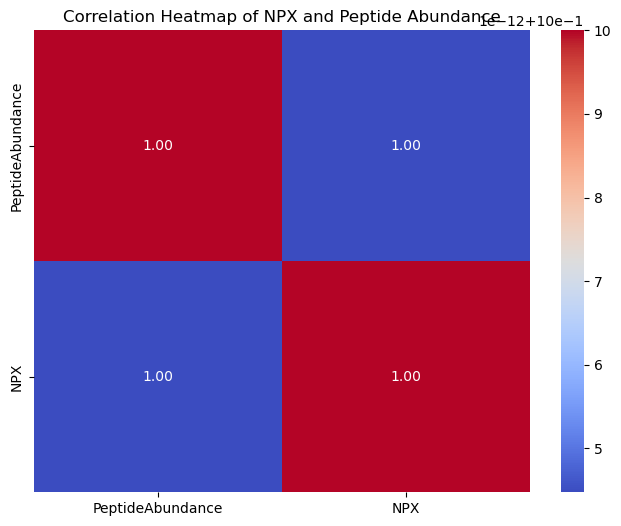

In [81]:

NPX_Pepetide_Ab = Final_clinical_data_graphical[['PeptideAbundance', 'NPX']]

correlation_matrix2 = NPX_Pepetide_Ab.corr()

# Creating the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of NPX and Peptide Abundance')
plt.show()


There is a very strong relationship between NPX and the summed Peptide abundance for each patient.Given the strong correlation we might consider using either NPX or Peptide Abundance for our machine learning model as they seem to capture similar infformation

In [82]:
Final_clinical_data_graphical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS,NPX,PeptideAbundance,Standardized_NPX,Peptide Abundance Standardized,UPDRS_Score
3,55_36,55,36,17.0,18.0,51.0,0.0,0,On,86.0,7.649231e+08,7.649234e+08,2.137472,2.137476,3
7,942_48,942,48,2.0,6.0,35.0,0.0,0,Off,43.0,5.979835e+08,5.979831e+08,0.333456,0.333452,2
11,1517_60,1517,60,19.0,18.0,39.0,10.0,0,Off,86.0,5.840639e+08,5.840636e+08,0.183036,0.183032,3
14,1923_36,1923,36,3.0,0.0,1.0,0.0,1,Unknown,4.0,7.711963e+08,7.711966e+08,2.205263,2.205267,0
18,2660_48,2660,48,6.0,0.0,0.0,0.0,1,Unknown,6.0,6.153522e+08,6.153520e+08,0.521149,0.521147,0


# III - Machine Learning

In [83]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer



Working with Total_UPDRS as the depndent variables and the rest of the fatures as independent variables

In [84]:
Final_ML = Final_clinical_data_graphical.drop(['PeptideAbundance','patient_id','visit_month', 'visit_id', 'Standardized_NPX', 'UPDRS_Score', 'Peptide Abundance Standardized'] , axis=1) 
# dropping Peptide Abundnace because it's has a perfect correelation with NPX better drop it for machine learning
Final_ML.head()


,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS,NPX
3,17.0,18.0,51.0,0.0,0,On,86.0,7.649231e+08
7,2.0,6.0,35.0,0.0,0,Off,43.0,5.979835e+08
11,19.0,18.0,39.0,10.0,0,Off,86.0,5.840639e+08
14,3.0,0.0,1.0,0.0,1,Unknown,4.0,7.711963e+08
18,6.0,0.0,0.0,0.0,1,Unknown,6.0,6.153522e+08


Next step would be that we have to transform thr clinical_state_on _medication values to dummies. 

In [85]:
Final_ML_dummies = pd.get_dummies(Final_ML, columns=['clinical_state_on_medication'], prefix='clinical_state')

In [86]:
Final_ML_dummies = Final_ML_dummies.astype(int)
Final_ML_dummies.head()

,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,Total_UPDRS,NPX,clinical_state_Off,clinical_state_On,clinical_state_Unknown
3,17,18,51,0,0,86,764923056,0,1,0
7,2,6,35,0,0,43,597983523,1,0,0
11,19,18,39,10,0,86,584063932,1,0,0
14,3,0,1,0,1,4,771196270,0,0,1
18,6,0,0,0,1,6,615352184,0,0,1


### 1 - Logistic Regression

In [87]:
Final_ML_dummies.shape
Final_ML.isnull().sum()
Final_ML_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 3 to 1067
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   updrs_1                 248 non-null    int32
 1   updrs_2                 248 non-null    int32
 2   updrs_3                 248 non-null    int32
 3   updrs_4                 248 non-null    int32
 4   updrs_4_missing         248 non-null    int32
 5   Total_UPDRS             248 non-null    int32
 6   NPX                     248 non-null    int32
 7   clinical_state_Off      248 non-null    int32
 8   clinical_state_On       248 non-null    int32
 9   clinical_state_Unknown  248 non-null    int32
dtypes: int32(10)
memory usage: 11.6 KB


In [88]:
# Defining our Features and targets
X = Final_ML_dummies[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_3', 'updrs_4', 'updrs_4_missing', 'NPX', 'clinical_state_Off', 'clinical_state_On', 'clinical_state_Unknown']]
y = Final_ML_dummies['Total_UPDRS']

In [89]:
print(X.shape)
print(y.shape)


(248, 10)
(248,)


In [90]:


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)


In [91]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)


LogReg = LogisticRegression()
LogReg.fit(X_train,y_train)
y_pred = LogReg.predict(X_test)


In [92]:
#Cross_Validation 

kf = KFold(n_splits=10, shuffle = True, random_state=3)
cv_results = cross_val_score(LogReg, X_train, y_train, cv=kf)
print(cv_results)

[0.05263158 0.05263158 0.         0.         0.05263158 0.05263158
 0.         0.         0.11111111 0.        ]


So the best KFold within our cross validation gives us an 0.111 accuracy which is about 11% model accuracy whhich is not Good at all 

In [207]:
# Trying to improve introducing Lasso l1 and Rigid l2 

In [208]:

# Train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Feature scaling
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

# Applying Logistic Regression with L1 (Lasso) regularization
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=3, max_iter=2000)
logreg_l1.fit(X1_train, y1_train)
y_pred_l1 = logreg_l1.predict(X1_test)

# Cross-validation with L1
kf = KFold(n_splits=10, shuffle=True, random_state=3)
cv_results_l1 = cross_val_score(logreg_l1, X, y, cv=kf)
print("Cross-validation results with L1 regularization:", cv_results_l1.mean())

# Applying Logistic Regression with L2 (Ridge) regularization
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', random_state=3, max_iter=2000)
logreg_l2.fit(X1_train, y1_train)
y_pred_l2 = logreg_l2.predict(X1_test)

# Cross-validation with L2
cv_results_l2 = cross_val_score(logreg_l2, X, y, cv=kf)
print("Cross-validation results with L2 regularization:", cv_results_l2.mean())


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


We can't seem to reduce the convergence of l1 and l2 there are two possible solutions we can either reduce the number of features or change the solver we are working with for one that is mor custom to a large set of features 

##### changing Solver

In [ ]:

# Train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Feature scaling
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

# Applying Logistic Regression with L1 (Lasso) regularization
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', random_state=3, max_iter=2000)
logreg_l1.fit(X1_train, y1_train)
y_pred_l1 = logreg_l1.predict(X1_test)

# Cross-validation with L1
kf = KFold(n_splits=10, shuffle=True, random_state=3)
cv_results_l1 = cross_val_score(logreg_l1, X, y, cv=kf)
print("Cross-validation results with L1 regularization:", cv_results_l1.mean())

# Applying Logistic Regression with L2 (Ridge) regularization
logreg_l2 = LogisticRegression(penalty='l2', solver='saga', random_state=3, max_iter=2000)
logreg_l2.fit(X1_train, y1_train)
y_pred_l2 = logreg_l2.predict(X1_test)

# Cross-validation with L2
cv_results_l2 = cross_val_score(logreg_l2, X, y, cv=kf)
print("Cross-validation results with L2 regularization:", cv_results_l2.mean())


Still not workiing we might have to consider using less features and test with other models

In [ ]:
Final_ML_dummies.head()

In [ ]:
Xless=  Final_ML_dummies[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'NPX']]

In [ ]:

# Train-test split
Xless_train, Xless_test, yl_train, yl_test = train_test_split(X_less, y, test_size=0.25, random_state=3)

# Feature scaling
scaler = StandardScaler()
Xless_train = scaler.fit_transform(Xless_train)
Xless_test = scaler.transform(Xless_test)

# Applying Logistic Regression with L1 (Lasso) regularization
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=3, max_iter=2000)
logreg_l1.fit(Xless_train, yl_train)
y_pred_l1 = logreg_l1.predict(Xless_test)

# Cross-validation with L1
kf = KFold(n_splits=10, shuffle=True, random_state=3)
cv_results_l1 = cross_val_score(logreg_l1, X, y, cv=kf)
print("Cross-validation results with L1 regularization:", cv_results_l1.mean())

# Applying Logistic Regression with L2 (Ridge) regularization
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', random_state=3, max_iter=2000)
logreg_l2.fit(Xless_train, yl_train)
y_pred_l2 = logreg_l2.predict(Xless_test)

# Cross-validation with L2
cv_results_l2 = cross_val_score(logreg_l2, X, y, cv=kf)
print("Cross-validation results with L2 regularization:", cv_results_l2.mean())


Same result it's best to try with a different model

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Define the parameter grid to search through
param_grid = {
    'max_depth': [3, 5, 7, 10, 12, 15, 18, 20],    # Different max depth values to try
    'min_samples_leaf': [1, 2, 4, 6]               # Different min samples leaf values to try
}

# Create a decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Use GridSearchCV for cross-validation and parameter tuning
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Evaluate the best estimator on the test set
test_accuracy = best_estimator.score(X_test, y_test)

print("Best Parameters:", best_params)
print("Test set accuracy of the best estimator:", test_accuracy)



Random forest

In [93]:
# Define a SMAPE metric
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

smape_scorer = make_scorer(smape, greater_is_better=False)

# Define our Features (X) and target variable (y)
X = Final_ML_dummies[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_3', 'updrs_4', 'updrs_4_missing', 'NPX', 'clinical_state_Off', 'clinical_state_On', 'clinical_state_Unknown']]
y = Final_ML_dummies['Total_UPDRS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor()

# Define the parameter grid for hyperparameter optimization
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters with SMAPE metric
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring=smape_scorer)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_estimator.predict(X_test_scaled)

# Evaluate the model's performance using SMAPE
smape_value = smape(y_test, y_pred)
print("Best Parameters:", best_params)
print("SMAPE:", smape_value)



Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
SMAPE: 12.366923409485622
